<a href="https://colab.research.google.com/github/Lorddickenstein/FSLRwithNLP/blob/main/Application/CNN_Model_Experiment5_Letters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 5
Folder: Experiment_5

Dataset Root: Preprocessed_Raw_Dataset

Dataset Experiment Root: Dataset_Preprocessed

Model: Custom Model

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Flatten, MaxPool2D, Conv2D, Dropout, BatchNormalization
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import glob
import warnings
import random
import shutil
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# Data Preparation

In [3]:
# Change the root folder when experimenting on a different folder
root = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Experiments/Experiment_4'

# Create Train, Valid, Test directories
train_path = os.path.join(root, 'Train')
valid_path = os.path.join(root, 'Valid')
test_path = os.path.join(root, 'Test')

letters = ['A', 'B', 'C', 'D', 'E',
           'F', 'G', 'H', 'I', 'J',
           'K', 'L', 'M', 'N', 'O',
           'P', 'Q', 'R', 'S', 'T',
           'U', 'V', 'W', 'X', 'Y',
           'Z']

In [4]:
# Function that creates the directory
def make_dir(path, class_obj):
  for obj in class_obj:
    path_class = os.path.join(path, obj)
    os.makedirs(path_class)

In [5]:
# Create a directory if train, valid, and test folders is empty or non-existent
if os.path.isdir(train_path) is False:
  make_dir(train_path, letters)
  make_dir(valid_path, letters)
  make_dir(test_path, letters)
else:
  print("Directory already exists.")


Directory already exists.


# Populate Train, Valid and Test Folders
Don't run if Train, Test, and Valid folders are populated

In [6]:
# Copy all images from preprocessed datasets folder to train folder
dataset_root = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Preprocessed_Raw_Dataset'
dataset_path = os.path.join(dataset_root, 'Letters')
flag = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Experiments/Experiment_4/Train/A'
if len(os.listdir(flag)) == 0:
  for letter in letters:
    path_class = os.path.join(dataset_path, letter)
    path_class_dest = os.path.join(train_path, letter)
    for item in os.listdir(path_class):
      shutil.copy(os.path.join(path_class, item), path_class_dest)
else:
  print("Directory already exists.")

Directory already exists.


Take samples from Train folder and put them to valid and test folders

Valid = 20 images

Test = 10 images

In [ ]:
valid_size = 20
test_size = 10

# Valid
for letter in letters:
  path_class = os.path.join(train_path, letter)
  os.chdir(path_class)
  if len(os.listdir(path_class)) != 0:
    for item in random.sample(glob.glob(letter + '_*'), valid_size):
      shutil.move(item, os.path.join(valid_path, letter))

# Test
for letter in letters:
  path_class = os.path.join(train_path, letter)
  os.chdir(path_class)
  if len(os.listdir(path_class)) != 0:
    for item in random.sample(glob.glob(letter + '_*'), test_size):
      shutil.move(item, os.path.join(test_path, letter))

In [7]:
# Verify number of images in Experiment
for letter in letters:
  train_path_experiment = os.path.join(train_path, letter)
  valid_path_experiment = os.path.join(valid_path, letter)
  test_path_experiment = os.path.join(test_path, letter)
  print(letter, len(os.listdir(train_path_experiment)), len(os.listdir(valid_path_experiment)), len(os.listdir(test_path_experiment)))

A 64 20 10
B 63 20 10
C 60 20 10
D 64 20 10
E 68 20 10
F 64 20 10
G 63 20 10
H 60 20 10
I 65 20 10
J 0 0 0
K 67 20 10
L 62 20 10
M 60 20 10
N 57 20 10
O 59 20 10
P 57 20 10
Q 55 20 10
R 53 20 10
S 57 20 10
T 56 20 10
U 52 20 10
V 65 20 10
W 66 20 10
X 63 20 10
Y 69 20 10
Z 0 0 0


# Preprocess Image

In [8]:
image_size = (120, 120)

In [9]:
def preprocess_func(src_img):
  norm = src_img.astype('float32')
  norm /= 255
  return norm

In [10]:
# Run if first time
train_batches = ImageDataGenerator(preprocessing_function=preprocess_func, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, fill_mode='constant') \
    .flow_from_directory(directory=train_path, target_size=image_size, classes=letters, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=preprocess_func,horizontal_flip=True, width_shift_range=0.15, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, fill_mode='constant') \
    .flow_from_directory(directory=valid_path, target_size=image_size, classes=letters, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=preprocess_func,horizontal_flip=True, width_shift_range=0.15, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, fill_mode='constant') \
    .flow_from_directory(directory=test_path, target_size=image_size, classes=letters, batch_size=10)

Found 1469 images belonging to 26 classes.
Found 480 images belonging to 26 classes.
Found 240 images belonging to 26 classes.


In [11]:
# Subtract empty class
assert train_batches.n == 1469
assert valid_batches.n == (20*26) - 40
assert test_batches.n == (10*26) - 20

In [12]:
imgs, labels = next(valid_batches)

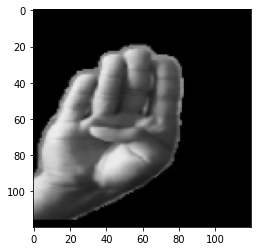

In [12]:
plt.imshow(imgs[0], cmap='gray')
plt.show()

In [13]:
# Plot 10 sample images
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

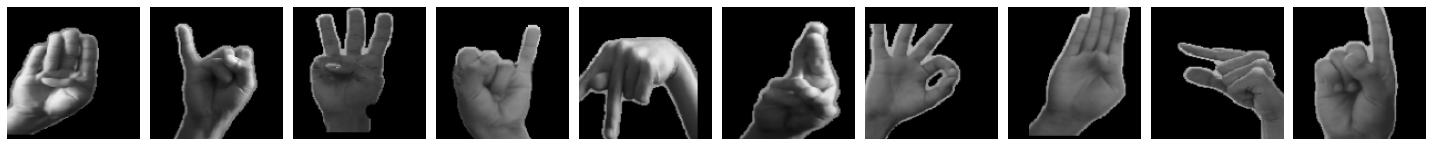

In [14]:
plotImages(imgs)

# Build the Model

In [13]:
# Count the total classes that the model must know
total_classes = len(os.listdir(train_path))
print(total_classes)

26


# Model #1 Custom Model
Choose only one model.

In [ ]:
# Create the Sequential Model
def create_model():
  model = Sequential()

  # Layers
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(120, 120, 3), padding='same'))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2), strides=2))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2), strides=2))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.20))
  model.add(Dense(total_classes, activation='softmax'))

  return model

# Model #2 VGG16
Choose only one model.

In [ ]:
# VGG16 Model
vgg16_model = keras.applications.vgg16.VGG16()

553476096/553467096 [==============================] - 4s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Create the model
model = Sequential()

# Copy the layer from the vgg16_model to model
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
# Add the prediction layer
model.add(Dense(total_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

# Create the model

In [ ]:
# Create Model function
model = create_model()
# Summary of layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0

# Save checkpoints during training
##Employing the following:

Checkpoints

CSV Logger

In [14]:
from keras.callbacks import ModelCheckpoint, CSVLogger

checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/CNN Models/Experiment_5/weights_improvements-epoch:{epoch:02d}-val_accuracy:{val_accuracy:.2f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 20
epochs = 10

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              verbose=1,
                              monitor='val_accuracy',
                              mode='max',
                              save_best_only=True,
                              period=5)

log_folder = '/content/drive/MyDrive/Colab Notebooks/CNN Models/Experiment_5'
log_path = os.path.join(log_folder, 'Experiment_5_logs.csv')
log_csv = CSVLogger(log_path, separator=',', append=True)

callback_list = [cp_callback, log_csv]

# Train the model

In [ ]:
# Create the connection and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# Train the model with the new callback
history = model.fit(x=train_batches,
                    validation_data=valid_batches,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callback_list)

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/10
147/147 [==============================] - 394s 3s/step - loss: 3.1791 - accuracy: 0.0796 - val_loss: 2.9128 - val_accuracy: 0.0958

Epoch 00001: val_accuracy improved from -inf to 0.09583, saving model to /content/drive/MyDrive/Colab Notebooks/CNN Models/Experiment_5/weights_improvements-01-0.10.hdf5
Epoch 2/10
147/147 [==============================] - 393s 3s/step - loss: 2.5240 - accuracy: 0.2471 - val_loss: 2.2247 - val_accuracy: 0.3229

Epoch 00002: val_accuracy improved from 0.09583 to 0.32292, saving model to /content/drive/MyDrive/Colab Notebooks/CNN Models/Experiment_5/weights_improvements-02-0.32.hdf5
Epoch 3/10
147/147 [==============================] - 392s 3s/step - loss: 2.0632 - accuracy: 0.3601 - val_loss: 2.0385 - val_accuracy: 0.3792

Epoch 00003: val_accuracy improved from 0.32292 to 0.37917, saving model to /content/drive/MyDrive/Colab Notebooks/CNN Models/Experiment_5/weights_improvements-03-0.38.hdf5
Epoch 4/10
147/147 [==============================] 

In [ ]:
# Evaluate the model with test_sets
print(model.evaluate(test_batches))

24/24 [==============================] - 15s 611ms/step - loss: 1.1750 - accuracy: 0.6292
[1.175017237663269, 0.6291666626930237]


In [ ]:
predictions = model.predict(x=test_batches, verbose=0)

# Confusion Matrix

In [ ]:
# Setup the confusion matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
test_batches.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25}

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 2 1 0 0 1 1]
 [0 0 0 3 0 0 0 2 0 0 0 0 2 0 0 0 0 1 1 0 0 0 0 1]
 [0 0 0 2 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 0]
 [0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 2 1 1 0]
 [0 1 0 0 0 0 1 0 0 0 2 0 0 0 1 1 0 1 0 1 1 0 1 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 2 1 0 1 0 0 1 0 2 0 1]
 [0 0 0 1 0 0 1 0 0 0 1 0 0 0 2 1 1 0 1 1 0 0 1 0]
 [1 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0]
 [0 3 2 0 0 0 0 0 0 0 1 1 0 0 0 0 0 2 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 3 0 1 0]
 [0 0 1 1 0 0 0 0 0 3 0 0 0 0 1 0 2 1 0 1 0 0 0 0]
 [0 0 2 0 1 0 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0 1 0 2]
 [0 1 0 0 1 0 0 1 1 0 3 0 1 0 0 0 0 0 0 0 0 1 1 0]
 [0 1 0 0 2 1 1 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 3 0 2 1 1 0 1 0 0 0 1 0 1 0 0 0 0]
 [1 1 0 0 1 0 0 1 0 0 1 0 0 2 1 1 0 0 0 0 0 0 1 0]
 [0 0 2 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 2 0 0 1 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 1 1 1 2 0 0 1 1 0 1 

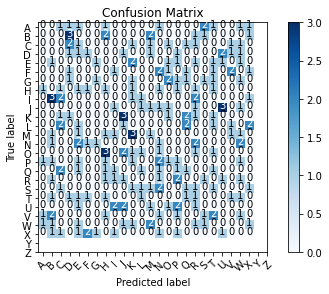

In [ ]:
# Plot the confusion matrix
cm_plot_labels = letters
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Model Path Config

In [24]:
model_name = 'Fingerspell_Detector_Experiment5(45-epochs)-accuracy:0.89-val_accuracy:0.85.h5'
path = '/content/drive/MyDrive/Colab Notebooks/CNN Models/Experiment_5'
model_path = os.path.join(path, model_name)

# Save the Model

In [ ]:
# save the model
model.save(model_path)

# Resume Training

In [37]:
# Load Model
new_model = load_model(model_path)

In [38]:
# Test model before resuming training
print(new_model.evaluate(test_batches, verbose=0))

[0.4766094982624054, 0.8791666626930237]


In [39]:
# Resume Training
new_model.fit(x=train_batches,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=valid_batches,
          callbacks=callback_list)

Epoch 1/10
147/147 [==============================] - 451s 3s/step - loss: 0.2809 - accuracy: 0.9095 - val_loss: 0.4931 - val_accuracy: 0.8396
Epoch 2/10
147/147 [==============================] - 452s 3s/step - loss: 0.3152 - accuracy: 0.9074 - val_loss: 0.5391 - val_accuracy: 0.8521
Epoch 3/10
147/147 [==============================] - 454s 3s/step - loss: 0.2325 - accuracy: 0.9224 - val_loss: 0.3917 - val_accuracy: 0.8625
Epoch 4/10
147/147 [==============================] - 447s 3s/step - loss: 0.2777 - accuracy: 0.9101 - val_loss: 0.4665 - val_accuracy: 0.8354
Epoch 5/10
147/147 [==============================] - 445s 3s/step - loss: 0.2307 - accuracy: 0.9231 - val_loss: 0.5088 - val_accuracy: 0.8729

Epoch 00005: val_accuracy improved from 0.85833 to 0.87292, saving model to /content/drive/MyDrive/Colab Notebooks/CNN Models/Experiment_5/weights_improvements-epoch:05-val_accuracy:0.87.hdf5
Epoch 6/10
147/147 [==============================] - 447s 3s/step - loss: 0.2602 - accuracy

In [43]:
# Test model after training
print(new_model.evaluate(test_batches))

24/24 [==============================] - 17s 693ms/step - loss: 0.4181 - accuracy: 0.8792
[0.4180968999862671, 0.8791666626930237]


In [41]:
model_name = 'Fingerspell_Detector_Experiment5(65-epochs)-accuracy:0.87-val_accuracy:0.85.h5'
path = '/content/drive/MyDrive/Colab Notebooks/CNN Models/Experiment_5'
model_path = os.path.join(path, model_name)

In [42]:
new_model.save(model_path)

# Load Saved Models

In [31]:
cp_model = load_model('/content/drive/MyDrive/Colab Notebooks/CNN Models/Experiment_5/weights_improvements-epoch_05-val_accuracy_0.87.hdf5')

In [32]:
loss, acc = cp_model.evaluate(test_batches, verbose=2)
print("Restored model, accuracy: {:5.2f}%, loss: {:5.2f}%".format(100 * acc, 100 * loss))

24/24 - 17s - loss: 0.5135 - accuracy: 0.8583
Restored model, accuracy: 85.83%, loss: 51.35%


In [23]:
cp_model.save(model_path)